# 16.413 Final Project: Convex Risk Bounded Continuous-Time Trajectory Planning for a Europa Lander

Julia Briden (jbriden@mit.edu)
Kota Kondo (kkondo@mit.edu)
Lakshay Sharma (lakshays@mit.edu)
Nick Rober (nrober@mit.edu)
Youngjae Min (youngj0@mit.edu)

## 1. Problem Statement

The year is 2048 and alien life has been detected under the ice of Europa! In the interest of getting to know our newly discovered neighbors, NASA has decided to dispatch a highly specialized fleet of vehicles to the Gallilean moon. The mission will consist of (i) an autonomous underwater vehicle (AUV) designed to slowly glide to Europa's sea floor while transmitting data via an optical fiber cable to a rover on the surface, (ii) a surface rover designed to ferry the underwater vehicle from a safe landing site to an appropriate insertion site (i.e. vapor plume outburst location), and (iii) an orbiter, capable of relaying signals from the rover and providing high-resolution imagery to map the surface.

![alt text](environment_basic.jpg "Europa Lander mission concept")

As part of NASA's Jet Propulsion Laboratory, our team has been tasked with creating the trajectory generation algorithm for the surface vehicle. The goal for the rover is to navigate from a safe landing site which is flat and free of obstacles to the AUV's insertion point, which has relatively thin ice and may be surrounded by uncertain hazards. We have access to global map data within the field of operation, allowing us to formulate the trajectory generation problem as an infinite horizon mixed-integer nonlinear programming problem. We will solve this optimization problem using scipy.minimize and the Bernstein polynomial library BEBOT. To provide additional autonomy capabilities and give the optimization algorithm a good chance of finding a feasible solution, we will initilize the optimizer using RRT* to form an initial guess of the optimal trajectory.

### Formulation

Generally, this problem can be stated as an optimal control problem in the form of

***
<font size="3"><h1><center>$\underset{x(t)\in\mathbb{R}^{n_x},\;u(t)\in\mathbb{R}^{u_n}}{\text{minimize}}\quad E(x(0),\;x(1))+\int_{0}^{1}F(x(t),u(t))dt$ <div style="text-align: right"> (1) </div><br> $\begin{align} & \text{subject to} \quad \quad \\  \\ &\dot{x} = f(x(t),\;u(t)),\quad \forall t\in[0,1] \\ & e(x(0),\;x(1)) = 0, \\ & h(x(t),\;u(t)) \leq 0,\quad \forall t\in[0,1] \end{align}$</center></h1></font>
***

However, this is a difficult problem to solve. We can simplify it by considering that our system can be modelled using the common unicycle model:

***
<font size="3"><h1><center>$\dot{x} = \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{\phi} \end{bmatrix} = \begin{bmatrix} V \cos(\phi) \\ V \sin(\phi) \\ \omega \end{bmatrix}$</center></h1></font>
***

which is differentially flat. In this case, that is helpful because it means we can determine the inputs $V$ and $\omega$ directly from $x_1$ and $x_2$. Additionally, we can approximate $x(t)$ (the optimal trajectory) using a  Bernstein polynomial, which takes the form 

***
<font size="3"><h1><center>$x_N(t) = \sum_{i=0}^N \bar{x}_{i,N}b_{i,N}(t)$</center></h1></font>
***

where $\bar{x}_N = [\bar{x}_{0,N},\; ...,\; \bar{x}_{N,N}] \in \mathbb{R}^{n_x \times (N+1)}$, is a vector of control points for the Bernstein polynomial and 

***
<font size="3"><h1><center>$b_{i,N}(t) = \begin{pmatrix}N \\ i\end{pmatrix}t^i(1-t)^{N-i},\quad \begin{pmatrix}N \\ i\end{pmatrix} = \frac{N!}{i!(N-i)!}$</center></h1></font>
***

The use of Bernstein polynomials allows us to formulate the problem as a finite-dimensional optimization problem (choose N control points), rather than an infinite dimensional optimization problem. Additionally, Bernstein polynomials are fixed at the endpoints, (i.e. $x_N(t_0) = \bar{x}_{0,N}$ and $x_N(t_f) = \bar{x}_{N,N}$, allowing us to remove the equality constraint from (1). The fact that the model is differentially flat allows us to remove $u(t)$, and the convex hull property of Bernstein polynomials allows us to only evaluate the control points $\{x_{0,N}, ..., x_{N,N}\}$ for satisfaction of the inequality constraints. Thus, the simplified problem becomes

***
<font size="3"><h1><center>$\underset{\bar{x}_N}{\text{minimize}}\quad E(\bar{x}_{0,N},\;\bar{x}_{N,N})+\int_{0}^{1}F(x_N(t))dt$ <div style="text-align: right"> (2) </div><br> $\begin{align} & \text{subject to} \quad & \quad \\ & \|\dot{x}_N(t_i) - f(x_N(t_i)\| \leq 0, & \forall i \in \{0, 1, ..., N\} \\ & h(\bar{x}_{i,N}) \leq 0, & \forall i \in \{0, 1, ..., N\} \end{align}$</center></h1></font>
***

Finally, to address the inequality constraints $h(\bar{x}_{i,N})$, we list the necessary constraints on the system as

- Collision avoidance constraints (addressed below)
- Maximum and minimum speed constraints
- Maximum and minimum angular rate constraints

and plan to use total path length as the cost function to minimize the distance required by the rover to travel to the AUV insertion point.


From a practical standpoint, the scipy function minimize() can be used to solve problem (2). However, it requires an initial guess of the optimal trajectory as a starting point from which to begin using gradient descent. This guess warrants some consideration as it can have a large influence on the output of the function: one initial guess may give a good answer, while another may give local minima or even fail to converge to a solution. One option to generate this initial guess is to linearly interpolate between the initial and final positions. However it is often beneficial to give an initial guess which satisfies the system's constraints, which may not be the case if an obstacle lies on the straightline path between the initial and final positions. Thus, we plan to use RRT* as a fast way to generate what is hopefully a good initial guess.

Source: https://arxiv.org/pdf/1812.06132.pdf




## 2. Risk Contours

Risk contours are defined as the set of all points in uncertain environments with guaranteed bounded risk. We will use risk contours in finding optimal trajectories. 

For simplicity we incorporate only static risk contours into our problem, not dynamic contours, and replace probabilistic constraint with deterministic constraint in terms of x (use inner approximation of probabilisitic constraint to bound risk), which lead to rational polynomial representation.

### How to construct risk contours

Define $\chi \in \mathbb{R}^2$ as an uncertain environment where our ground robot explores and $\chi_{obs_{i}}(\omega_i) \subset \chi$, for $i = 1, ..., n_{o_{s}}$ as static uncertain obstacles, where $n_{o_{s}}$ is the number of static obstacles, $\omega_i$ is a probablistic uncertain parameters. 

Then, we can represent $\chi_{obs_{i}}(\omega_i)$ in terms of polynomials in x $\in \chi$

***
$\chi_{obs_{i}}(\omega_i) \equiv \{x \in \chi | P_i(x, \omega_i) \geq 0\}$ for i = 1, ..., $n_{o_{s}}$ (1)
***

where P_i : $\mathbb{R}^{n_x + n_{\omega}} \to \mathbb{R}$ denotes a given polynomial. Let $\triangle \in [0, 1]$ be a given acceptable risk level, and then, $C^{\triangle}_{r}$, static risk contour whose risk level, with less than the given acceptable can be defined as

***
$C^{\triangle}_{r} \equiv \{x \in \chi | Prob(x \in \chi_{obs}(\omega)) \leq \triangle\}$ (2)
***

By this definition, static risk contour is now defined with a deterministic constraint in terms of x. Furthermore, the static risk contour's inner approximation is given as

***
$\hat{C}^{\triangle}_{r} \equiv \{x  \in \chi | \frac{\mathbb{E}[P^2(x, \omega)] - \mathbb{E}[P(x, \omega)]^2}{\mathbb{E}[P^2(x, \omega)]} \leq \triangle  or  \mathbb{E}[P(x, \omega)] \leq 0 \}$ (3)
***

Since $\hat{C}^{\triangle}_{r}$ is an approximation of inner space of $C^{\triangle}_{r}$, any trajectory going through $\hat{C}^{\triangle}_{r}$ has a risk less or equal to the given $\triangle$.

*Convex Risk Bounded Continuous-Time Trajectory Planning in Uncertain Nonconvex Environments (https://arxiv.org/pdf/2106.05489.pdf)* gives a good expample to illustrate the use of this risk contour generation method.

### Function outline for generating random obstacles in the environment

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
from sympy import *
import random

from scipy.optimize import minimize, Bounds
from polynomial.bernstein import Bernstein

[!] Warning: OpenGJK library not installed.


In [2]:
## Function definition
#
# input
#    cx1: x1 offset
#    cx2: x2 offset
#
# output
#    g: polynomial that represents an obstacle, including probabilistic uncertain parameter, omega
#

def random_ob(cx1=0,cx2=0):
    # randomly generate obstacles within the given environments
    # return a list of polynomials generated according to the given shape, maximum size, and omega range
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    # radius of circle
    w = Symbol('w')
    
    # circular obstacle
    g = w**2-(x1-cx1)**2-(x2-cx2)**2
    
    return g

### Function outline for static risk contours 

In [3]:
## Function definition
#
# input
#    delta: acceptable risk level, [0,1]
#    g: polynomial that represents an obstacle, including probabilistic uncertain parameter, omega  
#    l: lower bound of uniform distribution for w
#    u: upper bound of uniform distribution for w
#
# output
#    C: the boundary of inner approximation of risk contour, which is denoted as a list of polynomials
#

def static_rc(g, delta, l, u):
    # calculate C using equation (3)
    # need to calculate expected values using the given polynomials
    # since delta is given, we can find the boundary of C as a form of a polynomial
    # may need another function to convert the given polynomial to another form. 
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    w = Symbol('w')
    
    degree = max(degree_list(g))
    
    # moments for w~Uniform[l,u]
    m_w = [1]
    
    for i in range(1,2*degree+1):
        m_w.append((1/(u-l))*((u**(i+1)-l**(i+1))/(i+1)))
                
    # first and second order moments
    Mg = []
    for i in range(1,3):
        Md = simplify(g**i)
        for j in range(i,i*degree):
            Md = Md.subs(w**j,m_w[j])
        Mg.append(Md)
    # risk contour
    C_1 = abs((Mg[1]-(Mg[0])**2)/(Mg[1]))
    C_2 = Mg[0]
    
    return [C_1,C_2]

### Function for checking if a point is safe

In [4]:
## Function definition
#
# input
#    delta: acceptable risk level, [0,1]
#    C: polynomial that represents equation 10 
#    x: x coordinate of point to check
#    y: y coordinate of point to check
#
# output
#    boolean: True if the point is safe and False if the point is unsafe
#

def check_safe(delta,C,x,y):
    # Evaluate equation 10 at a specified delta and x1,x2 coordinates to determine if a point is safe
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    
    C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
    
    if (C_array[0] <= delta and C_array[1] <= 0):
        return True
    else:
        return False

(0, 1)

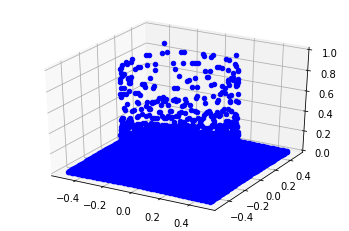

In [6]:
x_1 = np.linspace(-.5,.5,100)
x_2 = np.linspace(-.5,.5,100)
x1 = Symbol('x1')
x2 = Symbol('x2')

fig = plt.figure()
ax = plt.axes(projection='3d')

# obstacle equation
g = random_ob()
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.5,.3,.4)

for x in x_1:
    for y in x_2:
        C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
        ax.scatter3D(x, y, float(C_array[0]), color='b')
ax.set_zlim(0,1)

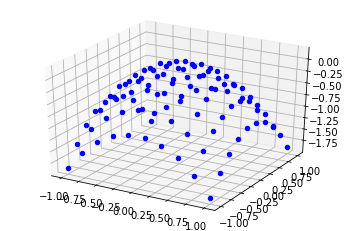

In [7]:
x_1 = np.linspace(-1,1,10)
x_2 = np.linspace(-1,1,10)
x1 = Symbol('x1')
x2 = Symbol('x2')

fig = plt.figure()
ax = plt.axes(projection='3d')

# obstacle equation
g = random_ob()
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.5,.3,.4)

for x in x_1:
    for y in x_2:
        C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
        ax.scatter3D(x, y, float(C_array[1]), color='b')

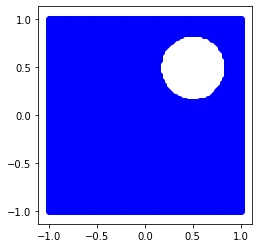

In [8]:
# Risk Contour Example: safe region with offset
x_1 = np.linspace(-1,1,100)
x_2 = np.linspace(-1,1,100)
x1 = Symbol('x1')
x2 = Symbol('x2')

# obstacle equation
g = random_ob(.5,.5)
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.5,.3,.4)

fig, ax = plt.subplots()
for x in x_1:
    for y in x_2:
        C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
        # equation 10
        if (C_array[0] <= .5 and C_array[1] <= 0):
            plt.scatter(x,y,color='b')
ax.set_aspect('equal')

0.3516923973503192

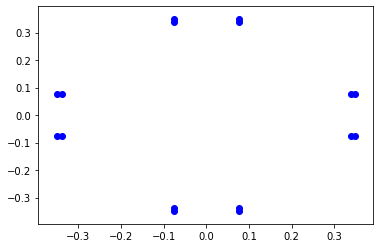

In [19]:
## Function definition
#
# input
#    C: polynomial that represents equation 10 
#    risk: acceptable risk for a given trajectory (contour risk delta)
#    center: (x,y) tuple of (known) center of expected object location
#
# output
#    float: estimated radius of given contour
#
def get_contour_radius(C, risk, center):
    # Risk Contour Example: safe region with offset
    xc = center[0]
    yc = center[1]
    x_1 = np.linspace(xc-0.5,xc+0.5,100)
    x_2 = np.linspace(yc-0.5,yc+0.5,100)
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    rad = []
    for x in x_1:
        for y in x_2:
            C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
            # equation 10
            if np.abs(C_array[0]) > risk-.05 and np.abs(C_array[0]) < risk+.05:
                rad.append(np.sqrt((x-xc)**2+(y-yc)**2))
                plt.scatter(x,y,color='b')
                if len(rad) > 20:
                    return np.mean(rad)
    return np.mean(rad)

g = random_ob()
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.5,.3,.4)

get_contour_radius(C,0.5,(0,0))


In [34]:
## Function definition
#
# input
#    num_obs: number of obstacles in the environment
#    risk: acceptable risk for a given trajectory (contour risk delta)
#    bounds: geographical bounds of environment
#
# output
#    centers: list of center locations of obstacles
#    radii: list of radius of risk contour of each obstacle
#
def get_obstacles(num_obs = 5, risk=0.5, bounds=np.array([[-1, 10], [-1, 10]])):
    random.seed(3)
    delta=risk # define acceptable risk
    span = bounds[:,1]-bounds[:,0] # define environment bounds
    border = 0.2 # obstacles should be fully contained in environment (allows us to place initial and final points)
    maxu = .5 # maximum obstacle upper bound
    minu = .2 # minimum obstacle upper bound
    
    # generate centers of obstacles
    xcs = [random.uniform(bounds[0,0]+border*span[0], bounds[0,1]-border*span[0]) for i in range(num_obs)]
    ycs = [random.uniform(bounds[1,0]+border*span[1], bounds[1,1]-border*span[1]) for i in range(num_obs)]
    centers = np.vstack((xcs,ycs))
    
    # generate upper and lower bound for obstacle diameters 
    us = np.array([random.uniform(minu, maxu) for i in range(num_obs)])
    ls = 0.8*us
    
    # create obstacles
    gs = [random_ob(xcs[i],ycs[i]) for i in range(num_obs)]
    
    # generate C equations for each obstacle
    C_list = [static_rc(gs[i],delta,ls[i],us[i]) for i in range(num_obs)]
    radii = []
    centers = []
    
    # find the radius of each risk contour
    for i, C in enumerate(C_list):
        center = [xcs[i], ycs[i]]
        radius = get_contour_radius(C,delta,center)
        radii.append(radius)
        centers.append(center)
    return np.array(centers), np.array(radii)

## 3. Continuous-Time Risk Bounded Trajectory Planning using Risk Contours


From part 2, we have formulated conditions for a point $x$ in a trajectory to be safe with the maximum risk of $\Delta$ to collide with uncertain static obstacles as below.

***
$\frac{\mathbb{E}[P^2(x, \omega)] - \mathbb{E}[P(x, \omega)]^2}{\mathbb{E}[P^2(x, \omega)]} \leq \Delta  \land  \mathbb{E}[P(x, \omega)] \leq 0 \$
***

With known momentums of $\omega$, the conditions are polynomial in $x$, and then the feasible set for the trajectory optimization problem can be presented as

***
$\mathcal{S}=\{x: g_i(x) \geq 0 \;\; i=1,\dots,l\}$
***

for some polynomials $g_i$. We are using RRT to find a trajectory in this feasible set to reach the goal state from the initial state. For RRT, we have to define two important functions STEER and ObstacleFree.

In [ ]:
class Tree_Node:
    def __init__(self, coord_x, coord_y, parent=None, children=[], cost=0):
        self.coord_x = coord_x
        self.coord_y = coord_y
        self.parent = parent
        self.children = [] + children
        self.cost = 0
    
    def distance(self, target):
        return np.sqrt((self.coord_x-target.coord_x)**2 + (self.coord_y-target.coord_y)**2)
    
    def Nearest(self, target):
        dist = self.distance(target)
        x_nearest = self
        if self.children == []:
            return dist, x_nearest
        for child in self.children:
            d_c, x_c = child.Nearest(target)
            if d_c < dist:
                dist = d_c
                x_nearest = x_c
        return dist, x_nearest
    
    def Arrive(self, goal):
        return self.coord_x == goal[0] and self.coord_y == goal[1]
    
    def Near(self, target, radius):
        X_near = []
        if self.distance(target) < radius:
            X_near.append(self)
        for child in self.children:
            X_near = X_near + child.Near(target, radius)
        return X_near

### Steer

Given a sampled point and the current state of the RRT tree, steer() finds the node in the RRT tree nearest to the sampled point, and generates a path from that node towards the sampled point (not necessarily ending at the sampled point) in the form of

***
$x(t) = \sum_{i=0}^d c_i t^i \;\; t \in [t_1, t_2]$
***

This path is added as an edge and the endpoint of this path is added as a new node to the RRT tree.


In [ ]:
## Function definition
#
# input
#    x_nearest: nearest point to x_rand in the RRT tree
#    x_rand: sampled point towards which the RRT tree needs to grow
#
# output
#    x_new: new point in the RRT tree
#

def Steer(x_nearest, x_rand, max_dist=2):
    dist = x_nearest.distance(x_rand)
    x_new = x_rand
    if dist > max_dist:
        x_new.coord_x = x_nearest.coord_x + (max_dist/dist)*(x_rand.coord_x-x_nearest.coord_x)
        x_new.coord_y = x_nearest.coord_y + (max_dist/dist)*(x_rand.coord_y-x_nearest.coord_y)
    return x_new

### ObstacleFree

To check the safety of the path defined above, one can use SOS-based continuous-time technique by checking whether each polynomial $g_i(x(t))$ can be represented with SOS polynomials as

***
$g_i(x(t)) = \sigma_{0i}(t) + \sigma_{1i}(t)(t-t_1) + \sigma_{2i}(t)(t_2-t)$
***

where $\sigma_{0i}(t), \sigma_{1i}(t), \sigma_{2i}(t)$ are SOS polynomials. This can be checked using Yalmip and Spotless packages, but for simplicity, we employ an apporximate collision-checking method.

We sample points along the extended path, and check for each point whether it resides in $\mathcal{S}$. By sampling densely enough, we can approximately check if the exented path is free from collision with obstacles.

In [ ]:
## Function definition
#
# input
#    x_nearest: the point closest to x_new
#    x_new: randomly chosen point by RRT
#    C_list: list of polynomials for each obstacle that represent equation 10 
#    delta: acceptable risk level, [0,1]
#
# output
#    boolean: True if the temporary trajectory that steer() function generates hits obstacles, otherwise False.
#

def ObstacleFree(x_nearest, x_new, C_list, delta): 
    # check if the newly generated line from x_nearest to x_new is violating the obstacle constraints.
    # put extra buffer around the line and check collisions using the given obstacles by env
    
    num_points = 10 # TODO: tunable, maybe pass in as arg?    
    
    for i in range(1, num_points + 1):
        x = x_nearest.coord_x + (i/num_points)*(x_new.coord_x-x_nearest.coord_x)
        y = x_nearest.coord_y + (i/num_points)*(x_new.coord_y-x_nearest.coord_y)
        for C in C_list:
            if not check_safe(delta, C, x, y):
                return False
    return True

### RRT* for trajectory generation

Then, using the functions defined above, we can employ RRT* to generate a trajectory with bounded risk $\Delta$ to collide with uncertain static obstacles.

In [ ]:
def SampleFree(i, goal, bounds):
    # sample a free point x_rand
    if i%20 == 0:
        x_rand = Tree_Node(goal[0], goal[1]) # goal-biasing
    else:
        ran = np.random.random_sample((2,))
        x_rand = Tree_Node((bounds[0][1]-bounds[0][0])*ran[0]+bounds[0][0], (bounds[1][1]-bounds[1][0])*ran[1]+bounds[1][0])
    return x_rand

In [ ]:
## Function definition
#
# input
#    init: initial sate of the robot
#    goal: goal state of the robot
#    C_list: list of polynomials for each obstacle that represent equation 10 
#    delta: acceptable risk level, [0,1]
#
# output
#    trajectory: list of successvie paths represented with parameters
#

def generate_trajectory(init, goal, C_list, delta):
    root = Tree_Node(init[0], init[1])
    N = 100000
    tree_node_num = 1
    # TODO: need to choose hyperparemters properly
    gamma = 10000 # for now, just big enough to choose eta in the minimum
    d = 2
    eta = 3.0
    trajectory = []
    for i in range(N):
        x_rand = SampleFree(i, goal, bounds)
        
        dist, x_nearest = root.Nearest(x_rand)
        if dist <= 1e-5:
            continue
        
        x_new = Steer(x_nearest, x_rand)
        
        if ObstacleFree(x_nearest, x_new, C_list, delta):
            X_near = root.Near(x_new, min(gamma*(log(tree_node_num)/tree_node_num)**(1/d), eta))
            
            x_min = x_nearest
            c_min = x_nearest.cost + x_nearest.distance(x_new)
            
            # Connect along a minimum-cost (minimum-distance) path
            for x_near in X_near:
                if ObstacleFree(x_near, x_new, C_list, delta) and x_near.cost + x_near.distance(x_new) < c_min:
                    x_min = x_near
                    c_min = x_near.cost + x_near.distance(x_new)
            
            x_new.parent = x_min
            x_new.cost = c_min
            x_min.children.append(x_new)
            
            # Rewire the tree
            for x_near in X_near:
                if ObstacleFree(x_new, x_near, C_list, delta) and x_new.cost + x_new.distance(x_near) < x_near.cost:
                    x_near.parent = x_new
                    x_near.cost = x_new.cost + x_new.distance(x_near)
                    x_new.children.append(x_near)
                
            if x_new.Arrive(goal):
                trajectory = [(x_new.coord_x, x_new.coord_y)]
                node = x_new
                while node.parent != None:
                    parent = node.parent
                    trajectory.insert(0, (parent.coord_x, parent.coord_y))
                    node = parent
                break
    return trajectory, x_new.cost

## Functions for Optimization

As mentioned previously, we will be using the scipy library function *minimize* to solve the problem given by Eq. 2 in Section 1. The use of this function requires the use of two support functions, namely a cost function *cost(xN)* which determines the cost of a given trajectory, and *nonlcon(xN, params)* which checks that the trajectory satisfies the constraints of the problem. The function stubs for these two functions, as well as the main optimization function are summarized below:

In [24]:
# Parameters for the current optimization problem.
class Parameters:
    def __init__(self, num_obstacles=8, env_bounds=np.array([[-1,10],[-1,10]])):
        self.deg = 7    # Degree of Bernstein polynomials being used
        self.tf = 20.0  # Final time estimate (will be )
        self.dsafe = 0.5  # Minimum safe distance between vehicle and obstacles
        self.vmax = 0.1  # Maximum speed
        self.wmax = 2*3*np.pi/2 # Maximum angular rate
        self.riskmax = 0.5 # Maximum allowable risk
        self.degree_elevation = 5

        self.pos0 = np.array([0,0],dtype=float) # Initial position
        self.posf = np.array([10,10],dtype=float) # Final points
        
        centers, radii = get_obstacles(num_obstacles, self.riskmax, env_bounds)
        self.obstacles = centers # obstacle positions
        self.safe_dists = radii # risk contour radius for each obstacle


In [25]:
## Function definition
#
# input
#    vector: vectorized set of control points being optimized + tf for current trajectory
#
# output
#    xN: matrix of control points for Bernstein polynomial
#    tf: time to execute the trajectory given by the bernstein polynomial described by xN
#
def reform(vector,params):
    N = int((len(vector)-1)/2)
    pos0 = params.pos0
    posf = params.posf
    x = np.concatenate(([pos0[0]], vector[0:N], [posf[0]]))
    y = np.concatenate(([pos0[1]], vector[N:-1], [posf[1]]))
    # pdb.set_trace()
    xN = np.vstack((x, y))
    tf = vector[-1]
    # pdb.set_trace()
    return xN, tf

In [26]:
## Function definition
#
# input
#    opt_vec: vectorized set of control points being optimized + tf for current trajectory
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max velocity, max angular velocity
#
# output
#    cost: the cost value of the control points given by the input
#

def cost(opt_vec,params): 
    xN, tf = reform(opt_vec,params)
    dist_sum = 0.0
    num_points = xN.shape[1]
    
    
    for i in range(num_points-1):
        dist = np.sqrt((xN[0][i]-xN[0][i+1])**2+(xN[1][i]-xN[1][i+1])**2)
        dist_sum += dist
    return dist_sum

In [27]:
## Function definition
#
# input
#    opt_vec: vectorized set of control points being optimized + tf for current trajectory
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max velocity, max angular velocity
#
# output
#    constraints: a vector of the constrained variables associated with the problem. Must be >=0 to be satisfied
#

def nonlcon(opt_vec, params): 
    # reform the optimization vector into an easy form to work with and unload problem parameters
    xN, tf = reform(opt_vec, params)
    degree_elevation = params.degree_elevation
    obstacles = params.obstacles
    safe_dists = params.safe_dists

    
    
    # generate bernstein polynomials from matrix of control points
    bp = Bernstein(xN, tf=tf)
    
    # find speed control points and use degree elevation to reduce conservativism
    speedN = bp.diff().normSquare().elev(degree_elevation).cpts.flatten() # Bernstein polynomial representing speed

    bpdot = bp.diff()
    bpddot = bpdot.diff()

    xdot = bpdot.x
    ydot = bpdot.y
    xddot = bpddot.x
    yddot = bpddot.y

    num = yddot*xdot - xddot*ydot
    den = xdot*xdot + ydot*ydot
    
    # find angular rate control points and use degree elevation to reduce conservativism
    wN = num.elev(degree_elevation).cpts / den.elev(degree_elevation).cpts
    wN = wN.flatten() # Rational bernstein polynomial representing angular rate
    
    # Obstacles:
    dist_bps = []
    dist_constraint = []
    for i, obs in enumerate(obstacles):
        obsN = np.ones((2, params.deg+1), dtype=float)
        obsN[0] *= obs[0]
        obsN[1] *= obs[1]
        # describe obstacles as constant bernstein polynomials
        obsbp = Bernstein(obsN,tf=tf)
        distbp = bp-obsbp
        dist_constraint.append(distbp.normSquare().elev(degree_elevation).cpts-safe_dists[i]**2) # control points 
                                                                                                 # representing dist-
                                                                                                 # ance to obstacle
        
    distN = np.array(dist_constraint).flatten() 
    
    # constraints: vector of points representing speed constraint, angular rate constraint, and distance to obstacles
    constraints = np.concatenate((params.vmax**2-speedN, params.wmax**2-wN, distN))
    
    return constraints

In [28]:
## Function definition
#
# input
#    x0: initial guess of control points created by generate_trajectory
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max and min velocity, max and min angular velocity
#
# output
#    xN_opt: set of control points representing the Bernstein polynomial approximation to the optimal trajectory
#

def generate_optimal_trajectory(x0, params): 
    # Use minimize function to generate an approximation to the optimal trajectory:
    # xN_opt = minimize(@(x)cost(x),x0,@(x)nonlcon(x,params))

    
    def fn(x): return cost(x, params)
    cons = [{'type': 'ineq',
             'fun': lambda x: nonlcon(x, params)}]
    bounds = Bounds(-1000, 1000)

    results = minimize(fn, x0,
                       constraints=cons,
                       bounds=bounds,
                       method='SLSQP',
                       options={'maxiter': 250,
                                'disp': True,
                                'iprint': 2})
    xN_opt, tf = reform(results.x, params)
    return xN_opt, tf

In [ ]:
num_obstacles = 8
env_bounds = np.array([[-1,10],[-1,10]])

params = Parameters(num_obstacles, env_bounds)

x0 = np.concatenate((np.linspace(1,9,params.deg-1), np.linspace(1,9,params.deg-1), [params.tf]))

xN_opt, tf = generate_optimal_trajectory(params)
bp = Bernstein(xN_opt,tf=tf)

print("tf: {} s".format(tf))

plt.close('all')
fig, ax = plt.subplots()

bp.plot(ax, showCpts=False,color='r')
pt10 = bp(5)
plt.plot(pt10[0], pt10[1], 'x', markeredgewidth=7, zorder=10, color='orange')

# for obs in params.obstacles:
#         obsArtist = plt.Circle(obs, radius=params.dsafe, edgecolor='Black')
#         ax.add_artist(obsArtist)

for i, obs in enumerate(params.obstacles):
        obsArtist = plt.Circle(obs, radius=params.safe_dists[i], edgecolor='Black')
        ax.add_artist(obsArtist)

ax.set_ylim([-1, 11])
ax.set_xlim([-1, 11])
ax.set_aspect('equal')